<a href="https://colab.research.google.com/github/chauhanneha16/Audio_Spoofing/blob/main/anti_spoofing_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d awsaf49/asvpoof-2019-dataset

Dataset URL: https://www.kaggle.com/datasets/awsaf49/asvpoof-2019-dataset
License(s): ODC Attribution License (ODC-By)
100% 23.6G/23.6G [03:06<00:00, 170MB/s]
100% 23.6G/23.6G [03:07<00:00, 135MB/s]


In [3]:

import zipfile
zip_ref = zipfile.ZipFile('/content/asvpoof-2019-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [4]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [5]:
# Define paths and parameters
DATASET_PATH = "/content/LA/LA/ASVspoof2019_LA_eval/flac"
LABEL_FILE_PATH = "/content/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins

In [6]:

labels = {}

with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    X.append(mel_spectrogram)
    y.append(label)

In [7]:
X = np.array(X)
y = np.array(y)

X,y

(array([[[-78.88214 , -80.      , -80.      , ...,   0.      ,
            0.      ,   0.      ],
         [-71.716606, -77.35332 , -80.      , ...,   0.      ,
            0.      ,   0.      ],
         [-57.146557, -59.502045, -57.573334, ...,   0.      ,
            0.      ,   0.      ],
         ...,
         [-69.18776 , -63.819813, -67.85419 , ...,   0.      ,
            0.      ,   0.      ],
         [-70.22391 , -64.85324 , -68.70045 , ...,   0.      ,
            0.      ,   0.      ],
         [-72.251236, -66.18086 , -68.856   , ...,   0.      ,
            0.      ,   0.      ]],
 
        [[-72.254776, -78.77455 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-69.8874  , -76.79361 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-57.00553 , -52.203255, -48.832603, ..., -73.142075,
          -71.93824 , -75.95265 ],
         ...,
         [-80.      , -68.084435, -64.63213 , ..., -47.64021 ,
          -42.370796, -4

In [12]:
y_encoded = to_categorical(y, num_classes=2)

In [13]:

split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y_encoded[:split_index], y_encoded[split_index:]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 109, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 107, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 53, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 51, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 25, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 48000)             0   

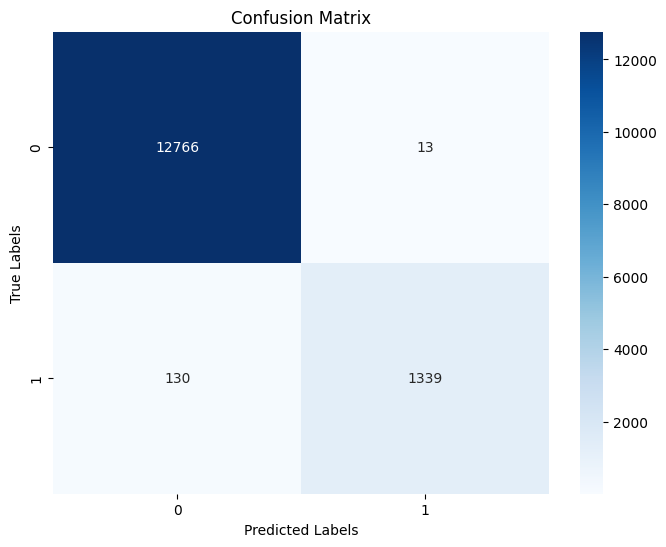

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model architecture
model_input = Input(shape=(N_MELS, max_time_steps, 1))
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
model_output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=model_input, outputs=model_output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Print the number of samples for training and testing
print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute genuine and impostor scores
genuine_scores = model.predict(X_test[y_test == 1]).flatten()
impostor_scores = model.predict(X_test[y_test == 0]).flatten()

# Concatenate genuine and impostor scores
scores = np.concatenate((genuine_scores, impostor_scores))

# Create labels for genuine and impostor scores
labels = np.concatenate((np.ones_like(genuine_scores), np.zeros_like(impostor_scores)))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, scores)

# Compute EER
eer_threshold = thresholds[np.nanargmin(np.abs(fpr - (1 - tpr)))]
eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]

print("EER:", eer)


400/400 [==============================] - 21s 53ms/step
EER: 0.015181156585022303


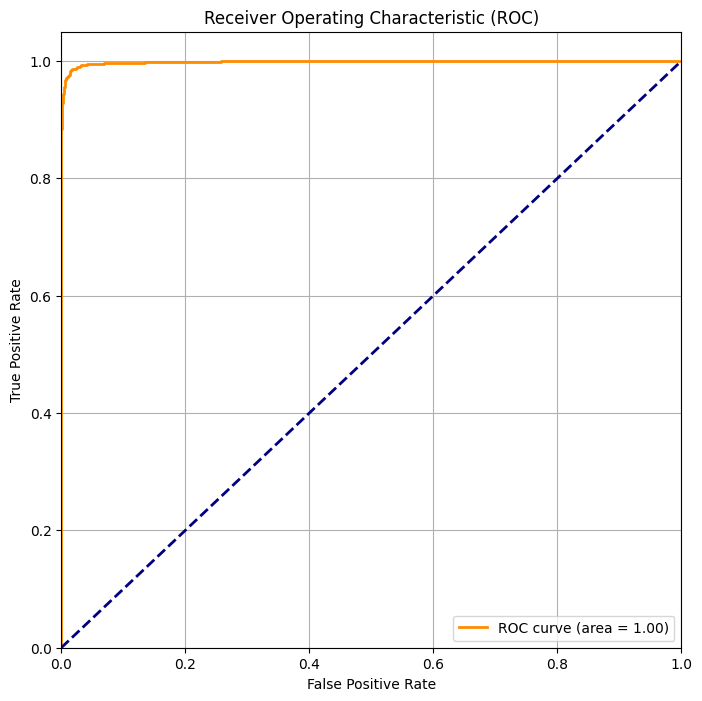

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



# Compute ROC curve
labels = np.concatenate((np.ones_like(genuine_scores), np.zeros_like(impostor_scores)))
scores = np.concatenate((genuine_scores, impostor_scores))
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [20]:
import tensorflow as tf

# Save the model in native Keras format
model.save("audio_classifier.keras")

In [33]:

import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/audio_classifier.keras')

# Preprocess random audio
def preprocess_audio(audio_file, sample_rate=16000, duration=5, n_mels=128, max_time_steps=109):
    audio, _ = librosa.load(audio_file, sr=sample_rate, duration=duration)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    return mel_spectrogram

# Make predictions
def predict_audio(model, audio_file):
    preprocessed_audio = preprocess_audio(audio_file)
    preprocessed_audio = np.expand_dims(preprocessed_audio, axis=0)  # Add batch dimension
    with tf.device('/CPU:0'):
        prediction = model.predict(preprocessed_audio)
    return prediction

# Path to your random audio file
random_audio_file = '/content/PA/PA/ASVspoof2019_PA_eval/flac/PA_E_0000410.flac'

# Get predictions
prediction = predict_audio(model, random_audio_file)

# Interpret the prediction
if np.argmax(prediction) == 0:
    print("The audio is predicted to be SPOOF")
else:
    print("The audio is predicted to be bonafide.")

1/1 [==============================] - 0s 105ms/step
The audio is predicted to be SPOOF
